In [ ]:
import h5py
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pde
from pprint import pprint
from IPython.display import Video

In [ ]:
slices = np.flip(np.arange(0.1,1.6,0.1)*10)
slices

array([15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,
        2.,  1.])

In [ ]:
slices = np.flip(np.arange(0.1,1.6,0.1)*10)

results = {'Slice {}%'.format(int(i)) : [] for i in slices}


for s in slices:
    
    ## LOAD DATA ## 

    data = h5py.File('./Data/Simulations/Quantum_Osc_w_1.h5')
    len_t = int(len(data['times'])*s/100)

    t = np.array(data['times'][:len_t])
    dt = t[1]-t[0]

    x = np.array(data['x'])
    dx = x[1]-x[0]

    u = np.array(data['data'][:len_t,:])
    u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)


    data.close()


    ## GET REAL AND IMG PART TO USE WITH SINDY ## 

    u_real = np.real(u)
    u_img = np.imag(u)


    u_dot_real = np.real(u_dot)
    u_dot_img = np.imag(u_dot)

    u_shaped = np.zeros(shape=(len(x), len(t), 3))
    u_shaped[:,:, 0]=u_real.T
    u_shaped[:,:, 1]=u_img.T
    u_shaped[:,:, 2]=np.tile(x,(len(t),1)).T # add x values to pass to u and u_dot (in these way one can introduce spatial potential terms)

    u_dot_shaped = np.zeros(shape=(len(x), len(t), 2))
    u_dot_shaped[:,:, 0]=u_dot_real.T
    u_dot_shaped[:,:, 1]=u_dot_img.T

    u_shaped.shape

    ## DEFINE CANDIDATES LIBRARY ## 

    # 2nd order poly library
    poly_library = ps.PolynomialLibrary(include_bias=False, degree=2) 

    # PDE library
    library_functions = [lambda x: x]
    library_function_names = [lambda x: x]
    pde_library = ps.PDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2, spatial_grid=x, 
                            include_bias=True, is_uniform=True, include_interaction=False)

    # Tensor polynomial library with the PDE library
    tensor_array = [[1, 1]]
    inputs_temp = np.tile([0, 1, 2], 2)
    inputs_per_library = np.reshape(inputs_temp, (2, 3))
    inputs_per_library[1,2] = 0 # only compute PDs for psi_real and psi_img
    inputs_per_library[0] = [2, 2, 2] # only compute polynomial for x input feature


    generalized_library = ps.GeneralizedLibrary(
        [poly_library, pde_library],
        tensor_array=tensor_array,
        inputs_per_library=inputs_per_library,
    )

    ## DEFINE OPTIMIZER AND FIT MODEL ## 

    optimizer = ps.STLSQ(threshold=0.1, verbose=True)
    model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi_r', 'psi_i', 'x'])
    model.fit(u_shaped, x_dot=u_dot_shaped, t=dt)
    model.print()

    #print(generalized_library.get_feature_names(), "\n")

    cf = model.coefficients()
    results['Slice {}%'.format(int(s))] = [cf[(cf != 0)]]

pprint(results, sort_dicts=False)

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 2.3533e+00 ... 4.9632e-02 ...          4 ... 2.4029e+00
         1 ... 8.3558e-02 ... 4.9921e-02 ...          4 ... 1.3348e-01
(psi_r)' = -0.500 psi_i_11 + 0.500 x^2 psi_i
(psi_i)' = 0.500 psi_r_11 + -0.500 x^2 psi_r
['x2', 'x2^2', '1', 'x0', 'x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x2 1', 'x2 x0', 'x2 x1', 'x2 x0_1', 'x2 x1_1', 'x2 x0_11', 'x2 x1_11', 'x2^2 1', 'x2^2 x0', 'x2^2 x1', 'x2^2 x0_1', 'x2^2 x1_1', 'x2^2 x0_11', 'x2^2 x1_11'] 

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 2.1859e+00 ... 4.9655e-02 ...          4 ... 2.2356e+00
         1 ... 7.9385e-02 ... 4.9921e-02 ...          4 ... 1.2931e-01
(psi_r)' = -0.500 psi_i_11 + 0.500 x^2 psi_i
(psi_i)' = 0.500 psi_r_11 + -0.500 x^2 psi_r
['x2', 'x2^2', '1', 'x0', 'x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x2 1', 'x2 x0', 'x2 x1', 'x2 x0_1', 'x2 x1_1', 'x2 

In [ ]:
model.equations(precision=16)

['-0.5003300259048450 psi_i_11 + 0.4995321466623165 x^2 psi_i',
 '0.5001539753043274 psi_r_11 + -0.4995913783343103 x^2 psi_r']

In [ ]:
M_res = np.zeros((len(slices),4))

for j,key in enumerate(results):
    
    if (len(results[key])==0): pass
    elif(len(results[key][0])==4):
        r = results[key][0]
        M_res[j]=np.array([r[0],r[1],r[2],r[3]])
    else: 
        r = results[key][0]
        M_res[j] = np.array(r)

print(M_res)

[[-0.49961371  0.49958222  0.49959785 -0.49962789]
 [-0.49962321  0.49957759  0.49960416 -0.49962426]
 [-0.49963579  0.49957286  0.49961243 -0.49962082]
 [-0.4996527   0.49956801  0.49962359 -0.49961758]
 [-0.49967575  0.49956302  0.49963894 -0.49961462]
 [-0.49973458  0.49955394  0.49968732 -0.49960814]
 [-0.49979189  0.49954679  0.49973042 -0.49960427]
 [-0.49987568  0.49953919  0.49979479 -0.4996005 ]
 [-0.49999933  0.49953214  0.4998937  -0.49959618]
 [-0.50010698  0.49953116  0.49997534 -0.49959244]
 [-0.50033003  0.49953215  0.50015398 -0.49959138]
 [-0.50069852  0.49952026  0.50035973 -0.49961517]
 [-0.50122265  0.49949711  0.50062101 -0.49966647]
 [-0.50153517  0.49953694  0.50113007 -0.49967514]
 [-0.50068966  0.49982027  0.50103067 -0.4997754 ]]


Text(0.5, 1.0, '$-x^2\\psi_i$ vs $x^2\\psi_r$')

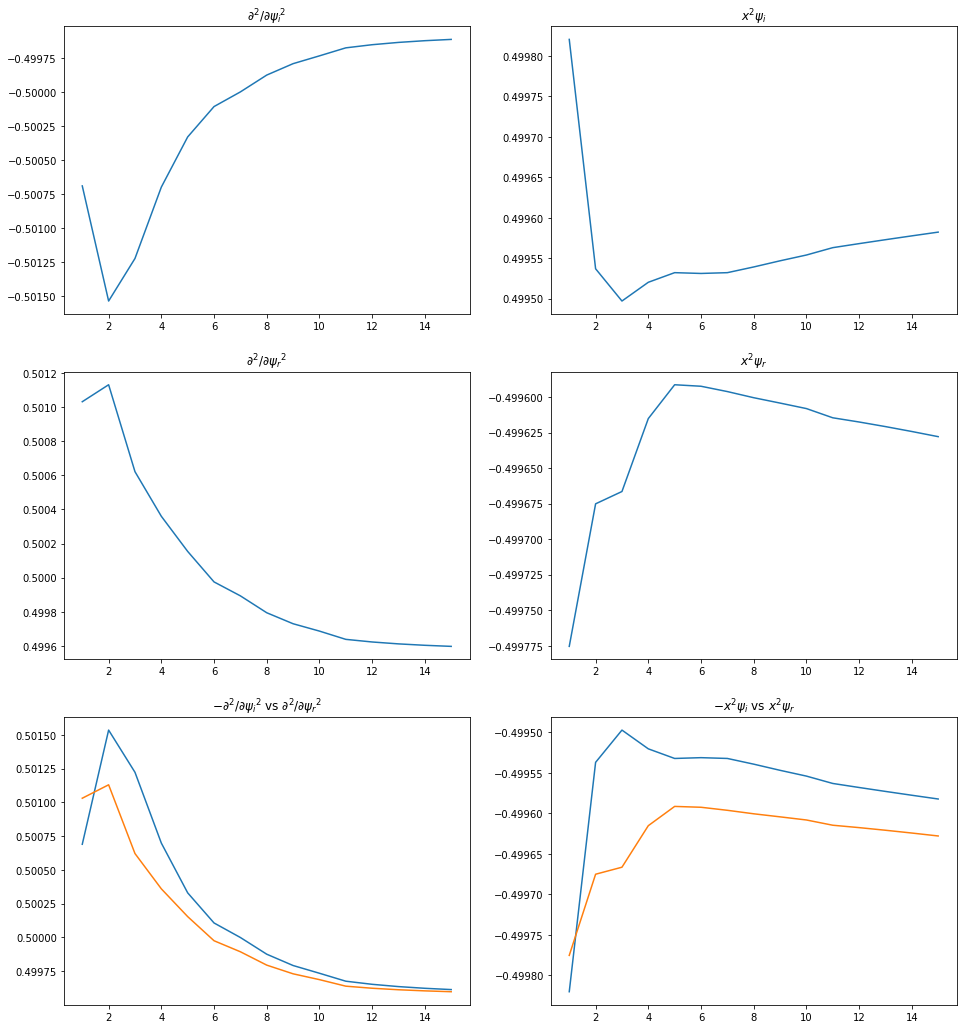

In [ ]:
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(3,2, figsize=(16,18))
ax1.plot(slices,M_res[:,0])
ax1.set_title('${\partial^2}/{\partial{\psi_i}^2}$')

ax2.plot(slices,M_res[:,1])
ax2.set_title('$x^2\psi_i$')

ax3.plot(slices,M_res[:,2])
ax3.set_title('${\partial^2}/{\partial{\psi_r}^2}$')

ax4.plot(slices,M_res[:,3])
ax4.set_title('$x^2\psi_r$')

ax5.plot(slices,-M_res[:,0])
ax5.plot(slices,M_res[:,2])
ax5.set_title('$-{\partial^2}/{\partial{\psi_i}^2}$ vs ${\partial^2}/{\partial{\psi_r}^2}$')

ax6.plot(slices,-M_res[:,1])
ax6.plot(slices,M_res[:,3])
ax6.set_title('$-x^2\psi_i$ vs $x^2\psi_r$')

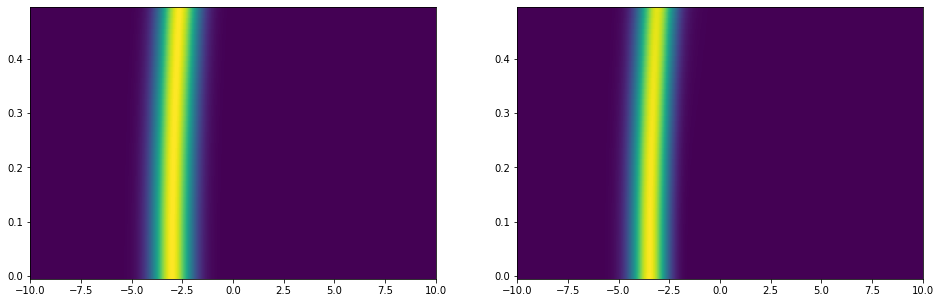

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.pcolormesh(x,t, np.abs(u)**2)
ax2.pcolormesh(x,t, np.abs(u_dot)**2)

In [ ]:
print(t.shape, x.shape, u.shape)

(251,) (1000,) (251, 1000)


## Fit reconstruction and simulation

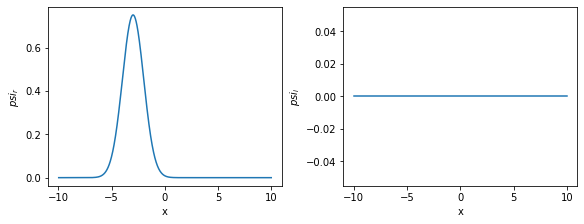

In [ ]:
## FITTED MODEL SIMULATION ## 

# TO DO: GENERALIZE EQUATION WRITING FROM MODEL RESULT

uxx_re = model.coefficients()[0,8]
uxx_im = model.coefficients()[1,7]
x2psi_re = model.coefficients()[0,18]
x2psi_im = model.coefficients()[1,17]
const_re = model.coefficients()[0,4]
const_im = model.coefficients()[1,3]


eq = pde.PDE({'psi_r':'{}*laplace(psi_i)+({}*x*x + {})*psi_i'.format(uxx_re, x2psi_re, const_re ), 
              'psi_i':'{}*laplace(psi_r)+({}*x*x + {})*psi_r'.format(uxx_im, x2psi_im, const_im)})

## DEFINE SPATIAL GRID ##

Nx = len(x) # number of spatial points
x_left = x[0]
x_right = x[-1]

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)
grid.coordinate_arrays = (x,) # this is needed otherwise endpoints are excluded

## DEFINE INITIAL STATE FOR SIMULATION (use last u entry) ##

initial_state_r = pde.ScalarField(grid, u_real[0], label= '$psi_r$')
initial_state_i = pde.ScalarField(grid, u_img[0], label = '$psi_i$')

initial_state = pde.FieldCollection([initial_state_r, initial_state_i])

initial_state.plot()


In [ ]:
## PERFORM SIMULATION ##

# define storage 
storage = pde.MemoryStorage() # for movie

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = 10
dt_sim = 1e-5

# points to use in animation 
N_t_anim = 500 # this is enough do not change it 
dt_anim = t_range/N_t_anim


solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_anim)])
_ = controller.run(initial_state, dt=dt_sim)

100%|██████████| 10.0/10.0 [12:33<00:00, 75.33s/it]


In [ ]:
## COMBINE REAL AND IMAGINARY PART ## 

data_sim = np.array([storage.data[i][0]+1j*storage.data[i][1] for i in range(len(storage))])
storage_sim = pde.MemoryStorage(times=t[0] + np.array(storage.times), data=data_sim, field_obj=pde.ScalarField(grid, label='$psi_sim$', dtype=np.complex128))


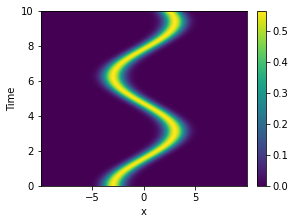

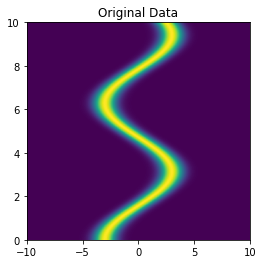

In [ ]:
## PLOT SIMULATION ##

pde.plot_kymographs(storage_sim, scalar='norm_squared')

data = h5py.File('./Data/Simulations/Quantum_Osc_w_1.h5')
t = np.array(data['times'])
x = np.array(data['x'])
u = np.array(data['data'])

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.pcolormesh(x, t, np.abs(u)**2)
plt.title('Original Data')
#plt.xlim(-10,10)
#plt.ylim(0,10.00001)
plt.show()

100%|██████████| 501/501 [00:38<00:00, 13.00it/s]


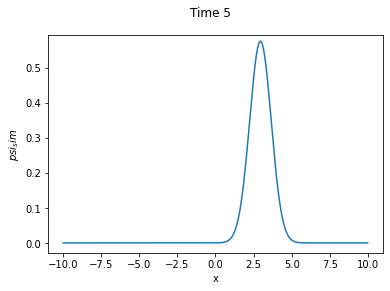

In [ ]:
## CREATE MOVIE ## 

pde.movie(storage_sim, 'broken_timestep_15.mp4', plot_args={'scalar':'norm_squared'}) # TODO: ADD LABELS 

In [ ]:
## VISUALIZE MOVIE ## Does not work in Deepnote...

Video('broken_timestep_15.mp4')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=964d390d-0269-41ab-86ee-4ee3752d1778' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>